# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['train_tfrecords',
 'train_images',
 'test_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_tfrecords']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

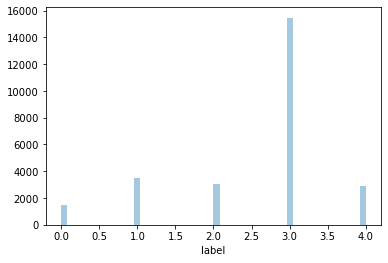

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = "tf_efficientnet_b3_ns"  # resnext50_32x4d, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 24
    gradient_accumulation_steps = 2
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 2234
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

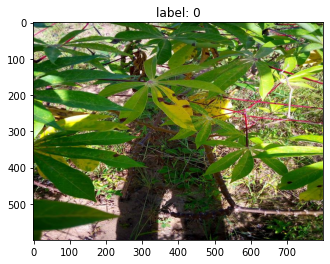

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

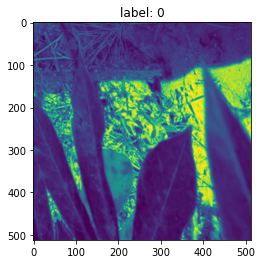

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if model_name == "resnext50_32x4d":
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0814, -0.0171,  0.1005,  0.0140, -0.1159],
        [ 0.2671,  0.1666, -0.0649,  0.1493, -0.0416],
        [ 0.0967,  0.0237,  0.0580,  0.0321, -0.0953],
        [ 0.5588,  0.5761, -0.1882,  0.3052,  0.1273]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        # elif mix_decision >= 0.5 and mix_decision < 0.75:
        #     images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.5:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [23]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/877] Elapsed 0m 2s (remain 31m 19s) Loss: 0.5143(0.5143) Grad: 0.2528 LR: 0.000100  
Epoch: [1][100/877] Elapsed 0m 34s (remain 4m 24s) Loss: 0.2099(0.3281) Grad: 0.2428 LR: 0.000100  
Epoch: [1][200/877] Elapsed 1m 6s (remain 3m 43s) Loss: 0.0881(0.2681) Grad: 0.2728 LR: 0.000100  
Epoch: [1][300/877] Elapsed 1m 38s (remain 3m 9s) Loss: 0.1432(0.2286) Grad: 0.3735 LR: 0.000100  
Epoch: [1][400/877] Elapsed 2m 11s (remain 2m 35s) Loss: 0.3283(0.2065) Grad: 0.4445 LR: 0.000099  
Epoch: [1][500/877] Elapsed 2m 43s (remain 2m 2s) Loss: 0.2511(0.1931) Grad: 0.5777 LR: 0.000099  
Epoch: [1][600/877] Elapsed 3m 15s (remain 1m 29s) Loss: 0.1814(0.1819) Grad: 0.4862 LR: 0.000099  
Epoch: [1][700/877] Elapsed 3m 47s (remain 0m 57s) Loss: 0.1654(0.1733) Grad: 0.3958 LR: 0.000098  
Epoch: [1][800/877] Elapsed 4m 20s (remain 0m 24s) Loss: 0.1005(0.1673) Grad: 0.3285 LR: 0.000098  
Epoch: [1][876/877] Elapsed 4m 44s (remain 0m 0s) Loss: 0.0820(0.1637) Grad: 0.3117 LR: 0.000098  
EVAL: 

Epoch 1 - avg_train_loss: 0.1637  avg_val_loss: 0.1120  time: 325s
Epoch 1 - Accuracy: 0.8768033409263477
Epoch 1 - Save Best Score: 0.8768 Model


EVAL: [219/220] Elapsed 0m 40s (remain 0m 0s) Loss: 0.2319(0.1120) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 22m 12s) Loss: 0.0941(0.0941) Grad: 0.4738 LR: 0.000098  
Epoch: [2][100/877] Elapsed 0m 34s (remain 4m 22s) Loss: 0.0761(0.0920) Grad: 0.2839 LR: 0.000097  
Epoch: [2][200/877] Elapsed 1m 6s (remain 3m 43s) Loss: 0.1013(0.0932) Grad: 0.4782 LR: 0.000096  
Epoch: [2][300/877] Elapsed 1m 38s (remain 3m 7s) Loss: 0.1276(0.0896) Grad: 0.2895 LR: 0.000096  
Epoch: [2][400/877] Elapsed 2m 10s (remain 2m 34s) Loss: 0.1581(0.0890) Grad: 0.3549 LR: 0.000095  
Epoch: [2][500/877] Elapsed 2m 42s (remain 2m 1s) Loss: 0.1372(0.0894) Grad: 0.4117 LR: 0.000094  
Epoch: [2][600/877] Elapsed 3m 14s (remain 1m 29s) Loss: 0.0691(0.0882) Grad: 0.3700 LR: 0.000093  
Epoch: [2][700/877] Elapsed 3m 46s (remain 0m 56s) Loss: 0.1013(0.0890) Grad: 0.3467 LR: 0.000092  
Epoch: [2][800/877] Elapsed 4m 18s (remain 0m 24s) Loss: 0.0123(0.0886) Grad: 0.1645 LR: 0.000091  
Epoch: [2][876/877] Elapsed 4m 42s (r

Epoch 2 - avg_train_loss: 0.0886  avg_val_loss: 0.1092  time: 321s
Epoch 2 - Accuracy: 0.8807896735003796
Epoch 2 - Save Best Score: 0.8808 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1470(0.1092) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 24m 31s) Loss: 0.2429(0.2429) Grad: 0.7452 LR: 0.000091  
Epoch: [3][100/877] Elapsed 0m 37s (remain 4m 46s) Loss: 0.1679(0.2115) Grad: 0.5614 LR: 0.000090  
Epoch: [3][200/877] Elapsed 1m 12s (remain 4m 4s) Loss: 0.1467(0.1977) Grad: 0.4413 LR: 0.000088  
Epoch: [3][300/877] Elapsed 1m 47s (remain 3m 25s) Loss: 0.2631(0.1996) Grad: 0.2399 LR: 0.000087  
Epoch: [3][400/877] Elapsed 2m 22s (remain 2m 49s) Loss: 0.1356(0.1910) Grad: 0.4383 LR: 0.000086  
Epoch: [3][500/877] Elapsed 2m 57s (remain 2m 13s) Loss: 0.2891(0.1917) Grad: 0.2490 LR: 0.000085  
Epoch: [3][600/877] Elapsed 3m 32s (remain 1m 37s) Loss: 0.1835(0.1912) Grad: 0.4214 LR: 0.000084  
Epoch: [3][700/877] Elapsed 4m 7s (remain 1m 2s) Loss: 0.2186(0.1905) Grad: 0.4052 LR: 0.000082  
Epoch: [3][800/877] Elapsed 4m 43s (remain 0m 26s) Loss: 0.1648(0.1917) Grad: 0.1513 LR: 0.000081  
Epoch: [3][876/877] Elapsed 5m 9s (re

Epoch 3 - avg_train_loss: 0.1910  avg_val_loss: 0.1090  time: 348s
Epoch 3 - Accuracy: 0.880030372057707


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1537(0.1090) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 23m 12s) Loss: 0.1365(0.1365) Grad: 0.3957 LR: 0.000080  
Epoch: [4][100/877] Elapsed 0m 37s (remain 4m 45s) Loss: 0.1616(0.1717) Grad: 0.3388 LR: 0.000078  
Epoch: [4][200/877] Elapsed 1m 12s (remain 4m 3s) Loss: 0.2263(0.1753) Grad: 0.2100 LR: 0.000077  
Epoch: [4][300/877] Elapsed 1m 47s (remain 3m 25s) Loss: 0.1661(0.1768) Grad: 0.3052 LR: 0.000075  
Epoch: [4][400/877] Elapsed 2m 22s (remain 2m 49s) Loss: 0.0974(0.1787) Grad: 0.3181 LR: 0.000074  
Epoch: [4][500/877] Elapsed 2m 57s (remain 2m 13s) Loss: 0.0801(0.1813) Grad: 0.3606 LR: 0.000072  
Epoch: [4][600/877] Elapsed 3m 32s (remain 1m 37s) Loss: 0.1858(0.1793) Grad: 0.2852 LR: 0.000071  
Epoch: [4][700/877] Elapsed 4m 7s (remain 1m 2s) Loss: 0.0675(0.1815) Grad: 0.3369 LR: 0.000069  
Epoch: [4][800/877] Elapsed 4m 43s (remain 0m 26s) Loss: 0.1498(0.1807) Grad: 0.3821 LR: 0.000067  
Epoch: [4][876/877] Elapsed 5m 9s (re

Epoch 4 - avg_train_loss: 0.1802  avg_val_loss: 0.1062  time: 348s
Epoch 4 - Accuracy: 0.8864844343204252
Epoch 4 - Save Best Score: 0.8865 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1532(0.1062) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 21m 36s) Loss: 0.1254(0.1254) Grad: 0.4473 LR: 0.000066  
Epoch: [5][100/877] Elapsed 0m 36s (remain 4m 42s) Loss: 0.1866(0.1623) Grad: 0.3016 LR: 0.000064  
Epoch: [5][200/877] Elapsed 1m 11s (remain 4m 1s) Loss: 0.1803(0.1674) Grad: 0.3460 LR: 0.000063  
Epoch: [5][300/877] Elapsed 1m 46s (remain 3m 24s) Loss: 0.0920(0.1704) Grad: 0.3216 LR: 0.000061  
Epoch: [5][400/877] Elapsed 2m 21s (remain 2m 48s) Loss: 0.3078(0.1696) Grad: 0.3032 LR: 0.000059  
Epoch: [5][500/877] Elapsed 2m 57s (remain 2m 12s) Loss: 0.1193(0.1710) Grad: 0.2808 LR: 0.000058  
Epoch: [5][600/877] Elapsed 3m 32s (remain 1m 37s) Loss: 0.1010(0.1708) Grad: 0.3304 LR: 0.000056  
Epoch: [5][700/877] Elapsed 4m 7s (remain 1m 2s) Loss: 0.2054(0.1731) Grad: 0.3955 LR: 0.000054  
Epoch: [5][800/877] Elapsed 4m 41s (remain 0m 26s) Loss: 0.1648(0.1709) Grad: 0.4548 LR: 0.000052  
Epoch: [5][876/877] Elapsed 5m 8s (re

Epoch 5 - avg_train_loss: 0.1702  avg_val_loss: 0.1040  time: 347s
Epoch 5 - Accuracy: 0.8861047835990888


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1957(0.1040) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 23m 35s) Loss: 0.1958(0.1958) Grad: 0.6253 LR: 0.000051  
Epoch: [6][100/877] Elapsed 0m 36s (remain 4m 40s) Loss: 0.2378(0.1756) Grad: 0.2711 LR: 0.000049  
Epoch: [6][200/877] Elapsed 1m 11s (remain 4m 0s) Loss: 0.0278(0.1768) Grad: 0.2084 LR: 0.000047  
Epoch: [6][300/877] Elapsed 1m 46s (remain 3m 24s) Loss: 0.2383(0.1748) Grad: 0.2744 LR: 0.000046  
Epoch: [6][400/877] Elapsed 2m 21s (remain 2m 47s) Loss: 0.1701(0.1773) Grad: 0.3936 LR: 0.000044  
Epoch: [6][500/877] Elapsed 2m 56s (remain 2m 12s) Loss: 0.2899(0.1747) Grad: 0.3350 LR: 0.000042  
Epoch: [6][600/877] Elapsed 3m 31s (remain 1m 36s) Loss: 0.1756(0.1770) Grad: 0.2230 LR: 0.000041  
Epoch: [6][700/877] Elapsed 4m 6s (remain 1m 1s) Loss: 0.1853(0.1746) Grad: 0.2913 LR: 0.000039  
Epoch: [6][800/877] Elapsed 4m 40s (remain 0m 26s) Loss: 0.1345(0.1720) Grad: 0.5209 LR: 0.000037  
Epoch: [6][876/877] Elapsed 5m 7s (re

Epoch 6 - avg_train_loss: 0.1717  avg_val_loss: 0.1034  time: 345s
Epoch 6 - Accuracy: 0.8881928625664389
Epoch 6 - Save Best Score: 0.8882 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.2044(0.1034) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 24m 2s) Loss: 0.2147(0.2147) Grad: 0.3782 LR: 0.000036  
Epoch: [7][100/877] Elapsed 0m 36s (remain 4m 36s) Loss: 0.0944(0.1412) Grad: 0.3172 LR: 0.000034  
Epoch: [7][200/877] Elapsed 1m 10s (remain 3m 55s) Loss: 0.0735(0.1383) Grad: 0.2879 LR: 0.000033  
Epoch: [7][300/877] Elapsed 1m 44s (remain 3m 20s) Loss: 0.3492(0.1417) Grad: 0.2654 LR: 0.000031  
Epoch: [7][400/877] Elapsed 2m 18s (remain 2m 44s) Loss: 0.1066(0.1403) Grad: 0.4763 LR: 0.000029  
Epoch: [7][500/877] Elapsed 2m 53s (remain 2m 9s) Loss: 0.0765(0.1397) Grad: 0.3232 LR: 0.000028  
Epoch: [7][600/877] Elapsed 3m 27s (remain 1m 35s) Loss: 0.1407(0.1405) Grad: 0.3698 LR: 0.000026  
Epoch: [7][700/877] Elapsed 4m 2s (remain 1m 0s) Loss: 0.1249(0.1395) Grad: 0.3328 LR: 0.000025  
Epoch: [7][800/877] Elapsed 4m 36s (remain 0m 26s) Loss: 0.0833(0.1394) Grad: 0.2886 LR: 0.000023  
Epoch: [7][876/877] Elapsed 5m 2s (rem

Epoch 7 - avg_train_loss: 0.1392  avg_val_loss: 0.1026  time: 341s
Epoch 7 - Accuracy: 0.8872437357630979


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.2016(0.1026) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 22m 26s) Loss: 0.1087(0.1087) Grad: 0.5269 LR: 0.000022  
Epoch: [8][100/877] Elapsed 0m 36s (remain 4m 38s) Loss: 0.1337(0.1550) Grad: 0.2911 LR: 0.000021  
Epoch: [8][200/877] Elapsed 1m 10s (remain 3m 57s) Loss: 0.1567(0.1380) Grad: 0.2637 LR: 0.000019  
Epoch: [8][300/877] Elapsed 1m 44s (remain 3m 20s) Loss: 0.0425(0.1346) Grad: 0.3555 LR: 0.000018  
Epoch: [8][400/877] Elapsed 2m 19s (remain 2m 45s) Loss: 0.0182(0.1343) Grad: 0.1606 LR: 0.000017  
Epoch: [8][500/877] Elapsed 2m 53s (remain 2m 10s) Loss: 0.1635(0.1323) Grad: 0.4674 LR: 0.000016  
Epoch: [8][600/877] Elapsed 3m 28s (remain 1m 35s) Loss: 0.0847(0.1327) Grad: 0.3565 LR: 0.000014  
Epoch: [8][700/877] Elapsed 4m 2s (remain 1m 0s) Loss: 0.0983(0.1330) Grad: 0.2733 LR: 0.000013  
Epoch: [8][800/877] Elapsed 4m 37s (remain 0m 26s) Loss: 0.0665(0.1327) Grad: 0.3963 LR: 0.000012  
Epoch: [8][876/877] Elapsed 5m 2s (r

Epoch 8 - avg_train_loss: 0.1329  avg_val_loss: 0.1018  time: 341s
Epoch 8 - Accuracy: 0.8870539104024298


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1799(0.1018) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 23m 7s) Loss: 0.2592(0.2592) Grad: 0.4307 LR: 0.000011  
Epoch: [9][100/877] Elapsed 0m 36s (remain 4m 37s) Loss: 0.0754(0.1361) Grad: 0.4511 LR: 0.000010  
Epoch: [9][200/877] Elapsed 1m 10s (remain 3m 57s) Loss: 0.1551(0.1320) Grad: 0.3669 LR: 0.000009  
Epoch: [9][300/877] Elapsed 1m 44s (remain 3m 20s) Loss: 0.1607(0.1273) Grad: 0.6095 LR: 0.000008  
Epoch: [9][400/877] Elapsed 2m 19s (remain 2m 45s) Loss: 0.3462(0.1288) Grad: 0.3670 LR: 0.000008  
Epoch: [9][500/877] Elapsed 2m 53s (remain 2m 10s) Loss: 0.1601(0.1277) Grad: 0.2482 LR: 0.000007  
Epoch: [9][600/877] Elapsed 3m 28s (remain 1m 35s) Loss: 0.0849(0.1294) Grad: 0.4729 LR: 0.000006  
Epoch: [9][700/877] Elapsed 4m 2s (remain 1m 0s) Loss: 0.2709(0.1292) Grad: 0.2528 LR: 0.000005  
Epoch: [9][800/877] Elapsed 4m 36s (remain 0m 26s) Loss: 0.0713(0.1285) Grad: 0.4092 LR: 0.000005  
Epoch: [9][876/877] Elapsed 5m 2s (re

Epoch 9 - avg_train_loss: 0.1277  avg_val_loss: 0.1009  time: 341s
Epoch 9 - Accuracy: 0.8891419893697798
Epoch 9 - Save Best Score: 0.8891 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1989(0.1009) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 18m 52s) Loss: 0.0324(0.0324) Grad: 0.4875 LR: 0.000004  
Epoch: [10][100/877] Elapsed 0m 33s (remain 4m 14s) Loss: 0.0797(0.0634) Grad: 0.3630 LR: 0.000004  
Epoch: [10][200/877] Elapsed 1m 4s (remain 3m 38s) Loss: 0.0142(0.0656) Grad: 0.1734 LR: 0.000003  
Epoch: [10][300/877] Elapsed 1m 36s (remain 3m 5s) Loss: 0.0648(0.0646) Grad: 0.3536 LR: 0.000003  
Epoch: [10][400/877] Elapsed 2m 8s (remain 2m 32s) Loss: 0.1539(0.0619) Grad: 0.4848 LR: 0.000003  
Epoch: [10][500/877] Elapsed 2m 40s (remain 2m 0s) Loss: 0.1698(0.0627) Grad: 0.5114 LR: 0.000002  
Epoch: [10][600/877] Elapsed 3m 11s (remain 1m 28s) Loss: 0.0665(0.0635) Grad: 0.5823 LR: 0.000002  
Epoch: [10][700/877] Elapsed 3m 43s (remain 0m 56s) Loss: 0.0549(0.0635) Grad: 0.1733 LR: 0.000002  
Epoch: [10][800/877] Elapsed 4m 15s (remain 0m 24s) Loss: 0.0200(0.0628) Grad: 0.2546 LR: 0.000002  
Epoch: [10][876/877] Elapsed 

Epoch 10 - avg_train_loss: 0.0638  avg_val_loss: 0.1037  time: 318s
Epoch 10 - Accuracy: 0.8883826879271071
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1822(0.1037) 


========== fold: 0 result ==========
Score: 0.88914
========== fold: 1 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 21m 1s) Loss: 0.4976(0.4976) Grad: 0.3448 LR: 0.000100  
Epoch: [1][100/877] Elapsed 0m 34s (remain 4m 28s) Loss: 0.2107(0.3064) Grad: 0.2871 LR: 0.000100  
Epoch: [1][200/877] Elapsed 1m 8s (remain 3m 49s) Loss: 0.1690(0.2569) Grad: 0.3782 LR: 0.000100  
Epoch: [1][300/877] Elapsed 1m 42s (remain 3m 15s) Loss: 0.1608(0.2251) Grad: 0.3540 LR: 0.000100  
Epoch: [1][400/877] Elapsed 2m 15s (remain 2m 40s) Loss: 0.1218(0.2049) Grad: 0.3950 LR: 0.000099  
Epoch: [1][500/877] Elapsed 2m 48s (remain 2m 6s) Loss: 0.1194(0.1902) Grad: 0.3352 LR: 0.000099  
Epoch: [1][600/877] Elapsed 3m 21s (remain 1m 32s) Loss: 0.1258(0.1805) Grad: 0.3356 LR: 0.000099  
Epoch: [1][700/877] Elapsed 3m 54s (remain 0m 58s) Loss: 0.0712(0.1714) Grad: 0.3435 LR: 0.000098  
Epoch: [1][800/877] Elapsed 4m 28s (remain 0m 25s) Loss: 0.0954(0.1661) Grad: 0.3265 LR: 0.000098  
Epoch: [1][876/877] Elapsed 4m 53s (remain 0m 0s) Loss: 0.1807(0.1614) Grad: 0.3732 LR: 0.000098  
EVAL: 

Epoch 1 - avg_train_loss: 0.1614  avg_val_loss: 0.1076  time: 331s
Epoch 1 - Accuracy: 0.8798405466970387
Epoch 1 - Save Best Score: 0.8798 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0981(0.1076) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 20m 29s) Loss: 0.1053(0.1053) Grad: 0.5451 LR: 0.000098  
Epoch: [2][100/877] Elapsed 0m 34s (remain 4m 28s) Loss: 0.1134(0.0873) Grad: 0.4883 LR: 0.000097  
Epoch: [2][200/877] Elapsed 1m 7s (remain 3m 48s) Loss: 0.1164(0.0859) Grad: 0.3927 LR: 0.000096  
Epoch: [2][300/877] Elapsed 1m 40s (remain 3m 13s) Loss: 0.0283(0.0843) Grad: 0.2800 LR: 0.000096  
Epoch: [2][400/877] Elapsed 2m 14s (remain 2m 39s) Loss: 0.1042(0.0876) Grad: 0.5019 LR: 0.000095  
Epoch: [2][500/877] Elapsed 2m 47s (remain 2m 5s) Loss: 0.0463(0.0886) Grad: 0.2295 LR: 0.000094  
Epoch: [2][600/877] Elapsed 3m 20s (remain 1m 32s) Loss: 0.0774(0.0877) Grad: 0.3861 LR: 0.000093  
Epoch: [2][700/877] Elapsed 3m 53s (remain 0m 58s) Loss: 0.1375(0.0896) Grad: 0.6945 LR: 0.000092  
Epoch: [2][800/877] Elapsed 4m 26s (remain 0m 25s) Loss: 0.1515(0.0903) Grad: 0.5190 LR: 0.000091  
Epoch: [2][876/877] Elapsed 4m 51s (

Epoch 2 - avg_train_loss: 0.0900  avg_val_loss: 0.1076  time: 330s
Epoch 2 - Accuracy: 0.8802201974183751
Epoch 2 - Save Best Score: 0.8802 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1563(0.1076) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 22m 25s) Loss: 0.1303(0.1303) Grad: 0.7833 LR: 0.000091  
Epoch: [3][100/877] Elapsed 0m 37s (remain 4m 49s) Loss: 0.2068(0.2170) Grad: 0.4991 LR: 0.000090  
Epoch: [3][200/877] Elapsed 1m 14s (remain 4m 9s) Loss: 0.1422(0.2082) Grad: 0.4081 LR: 0.000088  
Epoch: [3][300/877] Elapsed 1m 50s (remain 3m 30s) Loss: 0.1098(0.2077) Grad: 0.4433 LR: 0.000087  
Epoch: [3][400/877] Elapsed 2m 25s (remain 2m 53s) Loss: 0.1727(0.1998) Grad: 0.5101 LR: 0.000086  
Epoch: [3][500/877] Elapsed 3m 2s (remain 2m 16s) Loss: 0.2495(0.2001) Grad: 0.3256 LR: 0.000085  
Epoch: [3][600/877] Elapsed 3m 39s (remain 1m 40s) Loss: 0.1636(0.1956) Grad: 0.2124 LR: 0.000084  
Epoch: [3][700/877] Elapsed 4m 16s (remain 1m 4s) Loss: 0.1151(0.1956) Grad: 0.3530 LR: 0.000082  
Epoch: [3][800/877] Elapsed 4m 53s (remain 0m 27s) Loss: 0.1420(0.1946) Grad: 0.4584 LR: 0.000081  
Epoch: [3][876/877] Elapsed 5m 21s (r

Epoch 3 - avg_train_loss: 0.1937  avg_val_loss: 0.1122  time: 361s
Epoch 3 - Accuracy: 0.880030372057707


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0998(0.1122) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 27m 32s) Loss: 0.1378(0.1378) Grad: 0.5437 LR: 0.000080  
Epoch: [4][100/877] Elapsed 0m 39s (remain 5m 1s) Loss: 0.1281(0.1637) Grad: 0.3871 LR: 0.000078  
Epoch: [4][200/877] Elapsed 1m 16s (remain 4m 17s) Loss: 0.1779(0.1683) Grad: 0.4937 LR: 0.000077  
Epoch: [4][300/877] Elapsed 1m 53s (remain 3m 37s) Loss: 0.1779(0.1692) Grad: 0.3211 LR: 0.000075  
Epoch: [4][400/877] Elapsed 2m 30s (remain 2m 58s) Loss: 0.1450(0.1722) Grad: 0.5205 LR: 0.000074  
Epoch: [4][500/877] Elapsed 3m 7s (remain 2m 20s) Loss: 0.1447(0.1749) Grad: 0.4909 LR: 0.000072  
Epoch: [4][600/877] Elapsed 3m 44s (remain 1m 42s) Loss: 0.2007(0.1737) Grad: 0.2903 LR: 0.000071  
Epoch: [4][700/877] Elapsed 4m 20s (remain 1m 5s) Loss: 0.0902(0.1753) Grad: 0.3406 LR: 0.000069  
Epoch: [4][800/877] Elapsed 4m 56s (remain 0m 28s) Loss: 0.1471(0.1779) Grad: 0.3619 LR: 0.000067  
Epoch: [4][876/877] Elapsed 5m 23s (r

Epoch 4 - avg_train_loss: 0.1781  avg_val_loss: 0.1015  time: 361s
Epoch 4 - Accuracy: 0.8878132118451025
Epoch 4 - Save Best Score: 0.8878 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1260(0.1015) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 22m 55s) Loss: 0.3574(0.3574) Grad: 0.4672 LR: 0.000066  
Epoch: [5][100/877] Elapsed 0m 37s (remain 4m 51s) Loss: 0.1980(0.1825) Grad: 0.3110 LR: 0.000064  
Epoch: [5][200/877] Elapsed 1m 13s (remain 4m 7s) Loss: 0.2946(0.1717) Grad: 0.3495 LR: 0.000063  
Epoch: [5][300/877] Elapsed 1m 49s (remain 3m 29s) Loss: 0.3111(0.1740) Grad: 0.2066 LR: 0.000061  
Epoch: [5][400/877] Elapsed 2m 25s (remain 2m 52s) Loss: 0.1401(0.1731) Grad: 0.2069 LR: 0.000059  
Epoch: [5][500/877] Elapsed 3m 1s (remain 2m 16s) Loss: 0.2159(0.1741) Grad: 0.2572 LR: 0.000058  
Epoch: [5][600/877] Elapsed 3m 37s (remain 1m 39s) Loss: 0.1560(0.1739) Grad: 0.4061 LR: 0.000056  
Epoch: [5][700/877] Elapsed 4m 13s (remain 1m 3s) Loss: 0.1003(0.1741) Grad: 0.3005 LR: 0.000054  
Epoch: [5][800/877] Elapsed 4m 49s (remain 0m 27s) Loss: 0.2475(0.1747) Grad: 0.1985 LR: 0.000052  
Epoch: [5][876/877] Elapsed 5m 16s (r

Epoch 5 - avg_train_loss: 0.1744  avg_val_loss: 0.1031  time: 354s
Epoch 5 - Accuracy: 0.8853454821564161


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1117(0.1031) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 22m 23s) Loss: 0.3179(0.3179) Grad: 0.4345 LR: 0.000051  
Epoch: [6][100/877] Elapsed 0m 38s (remain 4m 52s) Loss: 0.1415(0.1612) Grad: 0.4556 LR: 0.000049  
Epoch: [6][200/877] Elapsed 1m 13s (remain 4m 8s) Loss: 0.1243(0.1693) Grad: 0.4461 LR: 0.000047  
Epoch: [6][300/877] Elapsed 1m 50s (remain 3m 30s) Loss: 0.1535(0.1702) Grad: 0.3160 LR: 0.000046  
Epoch: [6][400/877] Elapsed 2m 25s (remain 2m 53s) Loss: 0.2393(0.1712) Grad: 0.2840 LR: 0.000044  
Epoch: [6][500/877] Elapsed 3m 1s (remain 2m 16s) Loss: 0.1880(0.1706) Grad: 0.4391 LR: 0.000042  
Epoch: [6][600/877] Elapsed 3m 37s (remain 1m 39s) Loss: 0.0864(0.1687) Grad: 0.2848 LR: 0.000041  
Epoch: [6][700/877] Elapsed 4m 13s (remain 1m 3s) Loss: 0.0313(0.1694) Grad: 0.2847 LR: 0.000039  
Epoch: [6][800/877] Elapsed 4m 49s (remain 0m 27s) Loss: 0.0920(0.1690) Grad: 0.3563 LR: 0.000037  
Epoch: [6][876/877] Elapsed 5m 16s (r

Epoch 6 - avg_train_loss: 0.1708  avg_val_loss: 0.0998  time: 354s
Epoch 6 - Accuracy: 0.8925588458618071
Epoch 6 - Save Best Score: 0.8926 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1216(0.0998) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 22m 27s) Loss: 0.1098(0.1098) Grad: 0.5447 LR: 0.000036  
Epoch: [7][100/877] Elapsed 0m 37s (remain 4m 48s) Loss: 0.1363(0.1423) Grad: 0.3722 LR: 0.000034  
Epoch: [7][200/877] Elapsed 1m 12s (remain 4m 4s) Loss: 0.2503(0.1371) Grad: 0.1568 LR: 0.000033  
Epoch: [7][300/877] Elapsed 1m 48s (remain 3m 27s) Loss: 0.1425(0.1382) Grad: 0.3310 LR: 0.000031  
Epoch: [7][400/877] Elapsed 2m 23s (remain 2m 50s) Loss: 0.1166(0.1373) Grad: 0.4382 LR: 0.000029  
Epoch: [7][500/877] Elapsed 2m 59s (remain 2m 14s) Loss: 0.3220(0.1368) Grad: 0.3838 LR: 0.000028  
Epoch: [7][600/877] Elapsed 3m 34s (remain 1m 38s) Loss: 0.1053(0.1365) Grad: 0.4132 LR: 0.000026  
Epoch: [7][700/877] Elapsed 4m 10s (remain 1m 2s) Loss: 0.0887(0.1383) Grad: 0.3196 LR: 0.000025  
Epoch: [7][800/877] Elapsed 4m 46s (remain 0m 27s) Loss: 0.1290(0.1388) Grad: 0.4677 LR: 0.000023  
Epoch: [7][876/877] Elapsed 5m 13s (

Epoch 7 - avg_train_loss: 0.1399  avg_val_loss: 0.0964  time: 351s
Epoch 7 - Accuracy: 0.8952164009111617
Epoch 7 - Save Best Score: 0.8952 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1010(0.0964) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 25m 44s) Loss: 0.1786(0.1786) Grad: 0.4065 LR: 0.000022  
Epoch: [8][100/877] Elapsed 0m 37s (remain 4m 47s) Loss: 0.1719(0.1424) Grad: 0.1967 LR: 0.000021  
Epoch: [8][200/877] Elapsed 1m 12s (remain 4m 5s) Loss: 0.0793(0.1396) Grad: 0.3895 LR: 0.000019  
Epoch: [8][300/877] Elapsed 1m 48s (remain 3m 27s) Loss: 0.0840(0.1368) Grad: 0.4251 LR: 0.000018  
Epoch: [8][400/877] Elapsed 2m 23s (remain 2m 50s) Loss: 0.1297(0.1389) Grad: 0.4014 LR: 0.000017  
Epoch: [8][500/877] Elapsed 2m 59s (remain 2m 14s) Loss: 0.1555(0.1365) Grad: 0.4247 LR: 0.000016  
Epoch: [8][600/877] Elapsed 3m 34s (remain 1m 38s) Loss: 0.2933(0.1345) Grad: 0.3015 LR: 0.000014  
Epoch: [8][700/877] Elapsed 4m 9s (remain 1m 2s) Loss: 0.1018(0.1343) Grad: 0.4200 LR: 0.000013  
Epoch: [8][800/877] Elapsed 4m 44s (remain 0m 27s) Loss: 0.1970(0.1350) Grad: 0.1945 LR: 0.000012  
Epoch: [8][876/877] Elapsed 5m 11s (r

Epoch 8 - avg_train_loss: 0.1339  avg_val_loss: 0.0956  time: 350s
Epoch 8 - Accuracy: 0.8971146545178436
Epoch 8 - Save Best Score: 0.8971 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1010(0.0956) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 23m 12s) Loss: 0.0828(0.0828) Grad: 0.5681 LR: 0.000011  
Epoch: [9][100/877] Elapsed 0m 37s (remain 4m 51s) Loss: 0.1915(0.1241) Grad: 0.5513 LR: 0.000010  
Epoch: [9][200/877] Elapsed 1m 13s (remain 4m 8s) Loss: 0.1739(0.1304) Grad: 0.3845 LR: 0.000009  
Epoch: [9][300/877] Elapsed 1m 50s (remain 3m 30s) Loss: 0.2896(0.1301) Grad: 0.2442 LR: 0.000008  
Epoch: [9][400/877] Elapsed 2m 26s (remain 2m 54s) Loss: 0.0963(0.1308) Grad: 0.3839 LR: 0.000008  
Epoch: [9][500/877] Elapsed 3m 3s (remain 2m 17s) Loss: 0.3945(0.1306) Grad: 0.3799 LR: 0.000007  
Epoch: [9][600/877] Elapsed 3m 40s (remain 1m 41s) Loss: 0.0888(0.1309) Grad: 0.3150 LR: 0.000006  
Epoch: [9][700/877] Elapsed 4m 16s (remain 1m 4s) Loss: 0.0778(0.1325) Grad: 0.3102 LR: 0.000005  
Epoch: [9][800/877] Elapsed 4m 53s (remain 0m 27s) Loss: 0.0429(0.1332) Grad: 0.2911 LR: 0.000005  
Epoch: [9][876/877] Elapsed 5m 20s (r

Epoch 9 - avg_train_loss: 0.1331  avg_val_loss: 0.0950  time: 360s
Epoch 9 - Accuracy: 0.896545178435839


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0926(0.0950) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 24m 21s) Loss: 0.0400(0.0400) Grad: 0.5146 LR: 0.000004  
Epoch: [10][100/877] Elapsed 0m 35s (remain 4m 32s) Loss: 0.0207(0.0637) Grad: 0.1691 LR: 0.000004  
Epoch: [10][200/877] Elapsed 1m 9s (remain 3m 52s) Loss: 0.0942(0.0681) Grad: 0.3000 LR: 0.000003  
Epoch: [10][300/877] Elapsed 1m 42s (remain 3m 16s) Loss: 0.1090(0.0680) Grad: 0.3210 LR: 0.000003  
Epoch: [10][400/877] Elapsed 2m 15s (remain 2m 41s) Loss: 0.0314(0.0656) Grad: 0.2915 LR: 0.000003  
Epoch: [10][500/877] Elapsed 2m 50s (remain 2m 7s) Loss: 0.0402(0.0661) Grad: 0.3225 LR: 0.000002  
Epoch: [10][600/877] Elapsed 3m 23s (remain 1m 33s) Loss: 0.0081(0.0670) Grad: 0.1212 LR: 0.000002  
Epoch: [10][700/877] Elapsed 3m 56s (remain 0m 59s) Loss: 0.0542(0.0656) Grad: 0.3658 LR: 0.000002  
Epoch: [10][800/877] Elapsed 4m 29s (remain 0m 25s) Loss: 0.0488(0.0656) Grad: 0.3752 LR: 0.000002  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0649  avg_val_loss: 0.0975  time: 333s
Epoch 10 - Accuracy: 0.8952164009111617
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1068(0.0975) 


========== fold: 1 result ==========
Score: 0.89711
========== fold: 2 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 19m 10s) Loss: 0.5149(0.5149) Grad: 0.2915 LR: 0.000100  
Epoch: [1][100/877] Elapsed 0m 36s (remain 4m 38s) Loss: 0.1708(0.3323) Grad: 0.2613 LR: 0.000100  
Epoch: [1][200/877] Elapsed 1m 11s (remain 3m 59s) Loss: 0.1861(0.2632) Grad: 0.4502 LR: 0.000100  
Epoch: [1][300/877] Elapsed 1m 45s (remain 3m 22s) Loss: 0.0976(0.2239) Grad: 0.2933 LR: 0.000100  
Epoch: [1][400/877] Elapsed 2m 19s (remain 2m 46s) Loss: 0.0540(0.2041) Grad: 0.3692 LR: 0.000099  
Epoch: [1][500/877] Elapsed 2m 54s (remain 2m 10s) Loss: 0.1377(0.1895) Grad: 0.3601 LR: 0.000099  
Epoch: [1][600/877] Elapsed 3m 28s (remain 1m 35s) Loss: 0.0693(0.1802) Grad: 0.2652 LR: 0.000099  
Epoch: [1][700/877] Elapsed 4m 3s (remain 1m 1s) Loss: 0.1630(0.1713) Grad: 0.4957 LR: 0.000098  
Epoch: [1][800/877] Elapsed 4m 38s (remain 0m 26s) Loss: 0.0980(0.1651) Grad: 0.3794 LR: 0.000098  
Epoch: [1][876/877] Elapsed 5m 4s (remain 0m 0s) Loss: 0.1114(0.1615) Grad: 0.4746 LR: 0.000098  
EVAL: 

Epoch 1 - avg_train_loss: 0.1615  avg_val_loss: 0.1117  time: 342s
Epoch 1 - Accuracy: 0.8739320296183786
Epoch 1 - Save Best Score: 0.8739 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.3718(0.1117) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 21m 5s) Loss: 0.0315(0.0315) Grad: 0.5358 LR: 0.000098  
Epoch: [2][100/877] Elapsed 0m 35s (remain 4m 33s) Loss: 0.0749(0.1012) Grad: 0.3189 LR: 0.000097  
Epoch: [2][200/877] Elapsed 1m 10s (remain 3m 56s) Loss: 0.2658(0.0962) Grad: 0.5590 LR: 0.000096  
Epoch: [2][300/877] Elapsed 1m 44s (remain 3m 20s) Loss: 0.0715(0.0949) Grad: 0.4826 LR: 0.000096  
Epoch: [2][400/877] Elapsed 2m 19s (remain 2m 45s) Loss: 0.1221(0.0940) Grad: 0.5797 LR: 0.000095  
Epoch: [2][500/877] Elapsed 2m 54s (remain 2m 10s) Loss: 0.0312(0.0935) Grad: 0.2199 LR: 0.000094  
Epoch: [2][600/877] Elapsed 3m 29s (remain 1m 36s) Loss: 0.0579(0.0930) Grad: 0.5076 LR: 0.000093  
Epoch: [2][700/877] Elapsed 4m 3s (remain 1m 1s) Loss: 0.0169(0.0926) Grad: 0.1971 LR: 0.000092  
Epoch: [2][800/877] Elapsed 4m 38s (remain 0m 26s) Loss: 0.0076(0.0914) Grad: 0.1315 LR: 0.000091  
Epoch: [2][876/877] Elapsed 5m 4s (re

Epoch 2 - avg_train_loss: 0.0921  avg_val_loss: 0.1090  time: 342s
Epoch 2 - Accuracy: 0.8775393962407443
Epoch 2 - Save Best Score: 0.8775 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.3085(0.1090) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 26m 54s) Loss: 0.1654(0.1654) Grad: 0.7187 LR: 0.000091  
Epoch: [3][100/877] Elapsed 0m 39s (remain 5m 3s) Loss: 0.2951(0.2161) Grad: 0.3383 LR: 0.000090  
Epoch: [3][200/877] Elapsed 1m 16s (remain 4m 17s) Loss: 0.3465(0.2066) Grad: 0.3244 LR: 0.000088  
Epoch: [3][300/877] Elapsed 1m 54s (remain 3m 38s) Loss: 0.2535(0.1985) Grad: 0.2266 LR: 0.000087  
Epoch: [3][400/877] Elapsed 2m 31s (remain 3m 0s) Loss: 0.1239(0.1998) Grad: 0.3839 LR: 0.000086  
Epoch: [3][500/877] Elapsed 3m 9s (remain 2m 21s) Loss: 0.0904(0.1954) Grad: 0.3201 LR: 0.000085  
Epoch: [3][600/877] Elapsed 3m 46s (remain 1m 43s) Loss: 0.2983(0.1964) Grad: 0.2494 LR: 0.000084  
Epoch: [3][700/877] Elapsed 4m 23s (remain 1m 6s) Loss: 0.1168(0.1954) Grad: 0.2878 LR: 0.000082  
Epoch: [3][800/877] Elapsed 5m 0s (remain 0m 28s) Loss: 0.2773(0.1961) Grad: 0.2972 LR: 0.000081  
Epoch: [3][876/877] Elapsed 5m 27s (rem

Epoch 3 - avg_train_loss: 0.1951  avg_val_loss: 0.1039  time: 366s
Epoch 3 - Accuracy: 0.885323713689007
Epoch 3 - Save Best Score: 0.8853 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.2213(0.1039) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 23m 21s) Loss: 0.0571(0.0571) Grad: 0.5791 LR: 0.000080  
Epoch: [4][100/877] Elapsed 0m 38s (remain 4m 58s) Loss: 0.1264(0.1876) Grad: 0.3761 LR: 0.000078  
Epoch: [4][200/877] Elapsed 1m 15s (remain 4m 15s) Loss: 0.1114(0.1868) Grad: 0.3624 LR: 0.000077  
Epoch: [4][300/877] Elapsed 1m 52s (remain 3m 35s) Loss: 0.1243(0.1858) Grad: 0.4409 LR: 0.000075  
Epoch: [4][400/877] Elapsed 2m 29s (remain 2m 57s) Loss: 0.2871(0.1861) Grad: 0.1983 LR: 0.000074  
Epoch: [4][500/877] Elapsed 3m 6s (remain 2m 19s) Loss: 0.1771(0.1844) Grad: 0.4456 LR: 0.000072  
Epoch: [4][600/877] Elapsed 3m 43s (remain 1m 42s) Loss: 0.2258(0.1842) Grad: 0.2315 LR: 0.000071  
Epoch: [4][700/877] Elapsed 4m 20s (remain 1m 5s) Loss: 0.1421(0.1838) Grad: 0.3417 LR: 0.000069  
Epoch: [4][800/877] Elapsed 4m 57s (remain 0m 28s) Loss: 0.1017(0.1837) Grad: 0.4073 LR: 0.000067  
Epoch: [4][876/877] Elapsed 5m 24s (

Epoch 4 - avg_train_loss: 0.1825  avg_val_loss: 0.1055  time: 363s
Epoch 4 - Accuracy: 0.8796278716536928


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1979(0.1055) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 24m 7s) Loss: 0.3160(0.3160) Grad: 0.3983 LR: 0.000066  
Epoch: [5][100/877] Elapsed 0m 38s (remain 4m 59s) Loss: 0.1015(0.1716) Grad: 0.3526 LR: 0.000064  
Epoch: [5][200/877] Elapsed 1m 16s (remain 4m 16s) Loss: 0.2101(0.1744) Grad: 0.1655 LR: 0.000063  
Epoch: [5][300/877] Elapsed 1m 53s (remain 3m 36s) Loss: 0.2254(0.1759) Grad: 0.3234 LR: 0.000061  
Epoch: [5][400/877] Elapsed 2m 30s (remain 2m 58s) Loss: 0.2200(0.1729) Grad: 0.2363 LR: 0.000059  
Epoch: [5][500/877] Elapsed 3m 6s (remain 2m 20s) Loss: 0.0685(0.1742) Grad: 0.1601 LR: 0.000058  
Epoch: [5][600/877] Elapsed 3m 43s (remain 1m 42s) Loss: 0.1184(0.1760) Grad: 0.3992 LR: 0.000056  
Epoch: [5][700/877] Elapsed 4m 20s (remain 1m 5s) Loss: 0.1469(0.1760) Grad: 0.3691 LR: 0.000054  
Epoch: [5][800/877] Elapsed 4m 57s (remain 0m 28s) Loss: 0.1534(0.1759) Grad: 0.4392 LR: 0.000052  
Epoch: [5][876/877] Elapsed 5m 26s (r

Epoch 5 - avg_train_loss: 0.1752  avg_val_loss: 0.1052  time: 364s
Epoch 5 - Accuracy: 0.8847541294854756


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1970(0.1052) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 23m 55s) Loss: 0.2582(0.2582) Grad: 0.3659 LR: 0.000051  
Epoch: [6][100/877] Elapsed 0m 39s (remain 5m 0s) Loss: 0.2509(0.1668) Grad: 0.2480 LR: 0.000049  
Epoch: [6][200/877] Elapsed 1m 16s (remain 4m 16s) Loss: 0.2244(0.1748) Grad: 0.3918 LR: 0.000047  
Epoch: [6][300/877] Elapsed 1m 53s (remain 3m 36s) Loss: 0.0659(0.1732) Grad: 0.2461 LR: 0.000046  
Epoch: [6][400/877] Elapsed 2m 30s (remain 2m 58s) Loss: 0.1166(0.1716) Grad: 0.3316 LR: 0.000044  
Epoch: [6][500/877] Elapsed 3m 7s (remain 2m 20s) Loss: 0.1861(0.1680) Grad: 0.4151 LR: 0.000042  
Epoch: [6][600/877] Elapsed 3m 45s (remain 1m 43s) Loss: 0.2626(0.1708) Grad: 0.2169 LR: 0.000041  
Epoch: [6][700/877] Elapsed 4m 22s (remain 1m 5s) Loss: 0.3891(0.1717) Grad: 0.3269 LR: 0.000039  
Epoch: [6][800/877] Elapsed 4m 59s (remain 0m 28s) Loss: 0.2442(0.1736) Grad: 0.3537 LR: 0.000037  
Epoch: [6][876/877] Elapsed 5m 27s (r

Epoch 6 - avg_train_loss: 0.1754  avg_val_loss: 0.1032  time: 366s
Epoch 6 - Accuracy: 0.8872223277007785
Epoch 6 - Save Best Score: 0.8872 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1700(0.1032) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 23m 24s) Loss: 0.0687(0.0687) Grad: 0.5221 LR: 0.000036  
Epoch: [7][100/877] Elapsed 0m 38s (remain 4m 54s) Loss: 0.0538(0.1447) Grad: 0.4269 LR: 0.000034  
Epoch: [7][200/877] Elapsed 1m 15s (remain 4m 13s) Loss: 0.1203(0.1446) Grad: 0.2778 LR: 0.000033  
Epoch: [7][300/877] Elapsed 1m 51s (remain 3m 34s) Loss: 0.2195(0.1421) Grad: 0.4715 LR: 0.000031  
Epoch: [7][400/877] Elapsed 2m 28s (remain 2m 56s) Loss: 0.2298(0.1413) Grad: 0.2897 LR: 0.000029  
Epoch: [7][500/877] Elapsed 3m 4s (remain 2m 18s) Loss: 0.0929(0.1399) Grad: 0.3538 LR: 0.000028  
Epoch: [7][600/877] Elapsed 3m 41s (remain 1m 41s) Loss: 0.1438(0.1377) Grad: 0.5091 LR: 0.000026  
Epoch: [7][700/877] Elapsed 4m 17s (remain 1m 4s) Loss: 0.3400(0.1381) Grad: 0.2520 LR: 0.000025  
Epoch: [7][800/877] Elapsed 4m 53s (remain 0m 27s) Loss: 0.1415(0.1380) Grad: 0.4702 LR: 0.000023  
Epoch: [7][876/877] Elapsed 5m 21s (

Epoch 7 - avg_train_loss: 0.1377  avg_val_loss: 0.0998  time: 359s
Epoch 7 - Accuracy: 0.8885513575090184
Epoch 7 - Save Best Score: 0.8886 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1938(0.0998) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 23m 47s) Loss: 0.0871(0.0871) Grad: 0.4828 LR: 0.000022  
Epoch: [8][100/877] Elapsed 0m 38s (remain 4m 57s) Loss: 0.0723(0.1352) Grad: 0.4105 LR: 0.000021  
Epoch: [8][200/877] Elapsed 1m 15s (remain 4m 12s) Loss: 0.1625(0.1302) Grad: 0.3341 LR: 0.000019  
Epoch: [8][300/877] Elapsed 1m 51s (remain 3m 33s) Loss: 0.0948(0.1318) Grad: 0.3542 LR: 0.000018  
Epoch: [8][400/877] Elapsed 2m 27s (remain 2m 55s) Loss: 0.1760(0.1313) Grad: 0.2992 LR: 0.000017  
Epoch: [8][500/877] Elapsed 3m 4s (remain 2m 18s) Loss: 0.0404(0.1302) Grad: 0.2471 LR: 0.000016  
Epoch: [8][600/877] Elapsed 3m 40s (remain 1m 41s) Loss: 0.0633(0.1304) Grad: 0.3141 LR: 0.000014  
Epoch: [8][700/877] Elapsed 4m 17s (remain 1m 4s) Loss: 0.1350(0.1314) Grad: 0.4933 LR: 0.000013  
Epoch: [8][800/877] Elapsed 4m 54s (remain 0m 27s) Loss: 0.1127(0.1332) Grad: 0.3957 LR: 0.000012  
Epoch: [8][876/877] Elapsed 5m 21s (

Epoch 8 - avg_train_loss: 0.1322  avg_val_loss: 0.0975  time: 360s
Epoch 8 - Accuracy: 0.8896905259160812
Epoch 8 - Save Best Score: 0.8897 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1862(0.0975) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 24m 48s) Loss: 0.0606(0.0606) Grad: 0.5852 LR: 0.000011  
Epoch: [9][100/877] Elapsed 0m 38s (remain 4m 54s) Loss: 0.0809(0.1301) Grad: 0.1560 LR: 0.000010  
Epoch: [9][200/877] Elapsed 1m 14s (remain 4m 11s) Loss: 0.2169(0.1342) Grad: 0.3436 LR: 0.000009  
Epoch: [9][300/877] Elapsed 1m 51s (remain 3m 32s) Loss: 0.1130(0.1334) Grad: 0.3260 LR: 0.000008  
Epoch: [9][400/877] Elapsed 2m 27s (remain 2m 55s) Loss: 0.1424(0.1330) Grad: 0.3892 LR: 0.000008  
Epoch: [9][500/877] Elapsed 3m 4s (remain 2m 18s) Loss: 0.0463(0.1357) Grad: 0.3653 LR: 0.000007  
Epoch: [9][600/877] Elapsed 3m 41s (remain 1m 41s) Loss: 0.1254(0.1345) Grad: 0.4101 LR: 0.000006  
Epoch: [9][700/877] Elapsed 4m 17s (remain 1m 4s) Loss: 0.0801(0.1324) Grad: 0.5001 LR: 0.000005  
Epoch: [9][800/877] Elapsed 4m 54s (remain 0m 27s) Loss: 0.0466(0.1307) Grad: 0.2940 LR: 0.000005  
Epoch: [9][876/877] Elapsed 5m 22s (

Epoch 9 - avg_train_loss: 0.1297  avg_val_loss: 0.0970  time: 360s
Epoch 9 - Accuracy: 0.8898803873172584
Epoch 9 - Save Best Score: 0.8899 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.1926(0.0970) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 21m 20s) Loss: 0.0650(0.0650) Grad: 0.5877 LR: 0.000004  
Epoch: [10][100/877] Elapsed 0m 35s (remain 4m 36s) Loss: 0.0814(0.0647) Grad: 0.4471 LR: 0.000004  
Epoch: [10][200/877] Elapsed 1m 10s (remain 3m 57s) Loss: 0.0732(0.0658) Grad: 0.3674 LR: 0.000003  
Epoch: [10][300/877] Elapsed 1m 45s (remain 3m 21s) Loss: 0.0349(0.0663) Grad: 0.3384 LR: 0.000003  
Epoch: [10][400/877] Elapsed 2m 19s (remain 2m 45s) Loss: 0.0438(0.0656) Grad: 0.2719 LR: 0.000003  
Epoch: [10][500/877] Elapsed 2m 54s (remain 2m 10s) Loss: 0.0259(0.0652) Grad: 0.3255 LR: 0.000002  
Epoch: [10][600/877] Elapsed 3m 29s (remain 1m 36s) Loss: 0.0695(0.0655) Grad: 0.2327 LR: 0.000002  
Epoch: [10][700/877] Elapsed 4m 3s (remain 1m 1s) Loss: 0.1085(0.0653) Grad: 0.2332 LR: 0.000002  
Epoch: [10][800/877] Elapsed 4m 38s (remain 0m 26s) Loss: 0.0399(0.0648) Grad: 0.3238 LR: 0.000002  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0648  avg_val_loss: 0.0986  time: 342s
Epoch 10 - Accuracy: 0.8929181697360926
Epoch 10 - Save Best Score: 0.8929 Model


EVAL: [219/220] Elapsed 0m 37s (remain 0m 0s) Loss: 0.2264(0.0986) 


Epoch 10 - Save final model
========== fold: 2 result ==========
Score: 0.89292
========== fold: 3 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 23m 0s) Loss: 0.4794(0.4794) Grad: 0.3158 LR: 0.000100  
Epoch: [1][100/877] Elapsed 0m 37s (remain 4m 46s) Loss: 0.2418(0.3171) Grad: 0.2110 LR: 0.000100  
Epoch: [1][200/877] Elapsed 1m 13s (remain 4m 5s) Loss: 0.1373(0.2652) Grad: 0.1960 LR: 0.000100  
Epoch: [1][300/877] Elapsed 1m 48s (remain 3m 28s) Loss: 0.1045(0.2318) Grad: 0.3581 LR: 0.000100  
Epoch: [1][400/877] Elapsed 2m 24s (remain 2m 51s) Loss: 0.1937(0.2097) Grad: 0.3312 LR: 0.000099  
Epoch: [1][500/877] Elapsed 3m 0s (remain 2m 15s) Loss: 0.0951(0.1946) Grad: 0.3075 LR: 0.000099  
Epoch: [1][600/877] Elapsed 3m 35s (remain 1m 39s) Loss: 0.0776(0.1833) Grad: 0.2470 LR: 0.000099  
Epoch: [1][700/877] Elapsed 4m 11s (remain 1m 3s) Loss: 0.0648(0.1750) Grad: 0.3049 LR: 0.000098  
Epoch: [1][800/877] Elapsed 4m 47s (remain 0m 27s) Loss: 0.1079(0.1682) Grad: 0.4329 LR: 0.000098  
Epoch: [1][876/877] Elapsed 5m 14s (remain 0m 0s) Loss: 0.0880(0.1644) Grad: 0.3808 LR: 0.000098  
EVAL: [

Epoch 1 - avg_train_loss: 0.1644  avg_val_loss: 0.1097  time: 353s
Epoch 1 - Accuracy: 0.8781089804442757
Epoch 1 - Save Best Score: 0.8781 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0998(0.1097) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 21m 55s) Loss: 0.1710(0.1710) Grad: 0.5164 LR: 0.000098  
Epoch: [2][100/877] Elapsed 0m 37s (remain 4m 46s) Loss: 0.0730(0.0957) Grad: 0.2249 LR: 0.000097  
Epoch: [2][200/877] Elapsed 1m 13s (remain 4m 6s) Loss: 0.0617(0.0958) Grad: 0.3595 LR: 0.000096  
Epoch: [2][300/877] Elapsed 1m 49s (remain 3m 28s) Loss: 0.1443(0.0947) Grad: 0.4824 LR: 0.000096  
Epoch: [2][400/877] Elapsed 2m 24s (remain 2m 51s) Loss: 0.0819(0.0933) Grad: 0.4258 LR: 0.000095  
Epoch: [2][500/877] Elapsed 3m 0s (remain 2m 15s) Loss: 0.0374(0.0923) Grad: 0.3268 LR: 0.000094  
Epoch: [2][600/877] Elapsed 3m 36s (remain 1m 39s) Loss: 0.0421(0.0913) Grad: 0.4158 LR: 0.000093  
Epoch: [2][700/877] Elapsed 4m 12s (remain 1m 3s) Loss: 0.0486(0.0919) Grad: 0.4263 LR: 0.000092  
Epoch: [2][800/877] Elapsed 4m 48s (remain 0m 27s) Loss: 0.0184(0.0928) Grad: 0.2181 LR: 0.000091  
Epoch: [2][876/877] Elapsed 5m 15s (r

Epoch 2 - avg_train_loss: 0.0921  avg_val_loss: 0.1098  time: 354s
Epoch 2 - Accuracy: 0.8777292576419214


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1445(0.1098) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 26m 49s) Loss: 0.1837(0.1837) Grad: 0.6598 LR: 0.000091  
Epoch: [3][100/877] Elapsed 0m 40s (remain 5m 10s) Loss: 0.2313(0.2156) Grad: 0.2906 LR: 0.000090  
Epoch: [3][200/877] Elapsed 1m 19s (remain 4m 26s) Loss: 0.2685(0.2131) Grad: 0.3666 LR: 0.000088  
Epoch: [3][300/877] Elapsed 1m 57s (remain 3m 45s) Loss: 0.0819(0.2033) Grad: 0.3771 LR: 0.000087  
Epoch: [3][400/877] Elapsed 2m 35s (remain 3m 5s) Loss: 0.2307(0.1992) Grad: 0.3060 LR: 0.000086  
Epoch: [3][500/877] Elapsed 3m 14s (remain 2m 25s) Loss: 0.1040(0.1968) Grad: 0.3876 LR: 0.000085  
Epoch: [3][600/877] Elapsed 3m 52s (remain 1m 46s) Loss: 0.2279(0.1976) Grad: 0.2799 LR: 0.000084  
Epoch: [3][700/877] Elapsed 4m 30s (remain 1m 7s) Loss: 0.0637(0.1958) Grad: 0.3057 LR: 0.000082  
Epoch: [3][800/877] Elapsed 5m 8s (remain 0m 29s) Loss: 0.1822(0.1942) Grad: 0.3286 LR: 0.000081  
Epoch: [3][876/877] Elapsed 5m 38s (r

Epoch 3 - avg_train_loss: 0.1929  avg_val_loss: 0.1041  time: 377s
Epoch 3 - Accuracy: 0.8847541294854756
Epoch 3 - Save Best Score: 0.8848 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1196(0.1041) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 26m 54s) Loss: 0.1506(0.1506) Grad: 0.4150 LR: 0.000080  
Epoch: [4][100/877] Elapsed 0m 40s (remain 5m 8s) Loss: 0.2434(0.1754) Grad: 0.2150 LR: 0.000078  
Epoch: [4][200/877] Elapsed 1m 18s (remain 4m 23s) Loss: 0.2314(0.1790) Grad: 0.2298 LR: 0.000077  
Epoch: [4][300/877] Elapsed 1m 56s (remain 3m 43s) Loss: 0.1931(0.1768) Grad: 0.5096 LR: 0.000075  
Epoch: [4][400/877] Elapsed 2m 35s (remain 3m 4s) Loss: 0.1251(0.1796) Grad: 0.4246 LR: 0.000074  
Epoch: [4][500/877] Elapsed 3m 13s (remain 2m 25s) Loss: 0.2578(0.1790) Grad: 0.1932 LR: 0.000072  
Epoch: [4][600/877] Elapsed 3m 51s (remain 1m 46s) Loss: 0.3176(0.1789) Grad: 0.2388 LR: 0.000071  
Epoch: [4][700/877] Elapsed 4m 30s (remain 1m 7s) Loss: 0.0982(0.1810) Grad: 0.1812 LR: 0.000069  
Epoch: [4][800/877] Elapsed 5m 9s (remain 0m 29s) Loss: 0.0463(0.1802) Grad: 0.3371 LR: 0.000067  
Epoch: [4][876/877] Elapsed 5m 38s (re

Epoch 4 - avg_train_loss: 0.1799  avg_val_loss: 0.0988  time: 379s
Epoch 4 - Accuracy: 0.8927283083349156
Epoch 4 - Save Best Score: 0.8927 Model


EVAL: [219/220] Elapsed 0m 40s (remain 0m 0s) Loss: 0.1103(0.0988) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 28m 24s) Loss: 0.2398(0.2398) Grad: 0.4272 LR: 0.000066  
Epoch: [5][100/877] Elapsed 0m 41s (remain 5m 18s) Loss: 0.1018(0.1855) Grad: 0.2956 LR: 0.000064  
Epoch: [5][200/877] Elapsed 1m 20s (remain 4m 31s) Loss: 0.3262(0.1834) Grad: 0.3116 LR: 0.000063  
Epoch: [5][300/877] Elapsed 1m 59s (remain 3m 49s) Loss: 0.2499(0.1834) Grad: 0.2009 LR: 0.000061  
Epoch: [5][400/877] Elapsed 2m 38s (remain 3m 8s) Loss: 0.1031(0.1792) Grad: 0.4151 LR: 0.000059  
Epoch: [5][500/877] Elapsed 3m 17s (remain 2m 28s) Loss: 0.1809(0.1761) Grad: 0.1860 LR: 0.000058  
Epoch: [5][600/877] Elapsed 3m 56s (remain 1m 48s) Loss: 0.1274(0.1765) Grad: 0.3781 LR: 0.000056  
Epoch: [5][700/877] Elapsed 4m 35s (remain 1m 9s) Loss: 0.1091(0.1769) Grad: 0.3375 LR: 0.000054  
Epoch: [5][800/877] Elapsed 5m 14s (remain 0m 29s) Loss: 0.0658(0.1744) Grad: 0.3902 LR: 0.000052  
Epoch: [5][876/877] Elapsed 5m 42s (

Epoch 5 - avg_train_loss: 0.1735  avg_val_loss: 0.1033  time: 382s
Epoch 5 - Accuracy: 0.8876020505031327


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1290(0.1033) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 25m 36s) Loss: 0.3605(0.3605) Grad: 0.4740 LR: 0.000051  
Epoch: [6][100/877] Elapsed 0m 40s (remain 5m 12s) Loss: 0.1217(0.1767) Grad: 0.1887 LR: 0.000049  
Epoch: [6][200/877] Elapsed 1m 19s (remain 4m 26s) Loss: 0.2679(0.1718) Grad: 0.4223 LR: 0.000047  
Epoch: [6][300/877] Elapsed 1m 58s (remain 3m 45s) Loss: 0.0868(0.1734) Grad: 0.2939 LR: 0.000046  
Epoch: [6][400/877] Elapsed 2m 36s (remain 3m 5s) Loss: 0.1549(0.1737) Grad: 0.4112 LR: 0.000044  
Epoch: [6][500/877] Elapsed 3m 15s (remain 2m 26s) Loss: 0.1601(0.1734) Grad: 0.2796 LR: 0.000042  
Epoch: [6][600/877] Elapsed 3m 54s (remain 1m 47s) Loss: 0.0912(0.1736) Grad: 0.3878 LR: 0.000041  
Epoch: [6][700/877] Elapsed 4m 33s (remain 1m 8s) Loss: 0.3561(0.1721) Grad: 0.3010 LR: 0.000039  
Epoch: [6][800/877] Elapsed 5m 12s (remain 0m 29s) Loss: 0.1940(0.1724) Grad: 0.5527 LR: 0.000037  
Epoch: [6][876/877] Elapsed 5m 41s (

Epoch 6 - avg_train_loss: 0.1726  avg_val_loss: 0.0991  time: 381s
Epoch 6 - Accuracy: 0.8923485855325612


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1350(0.0991) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 24m 54s) Loss: 0.1226(0.1226) Grad: 0.4189 LR: 0.000036  
Epoch: [7][100/877] Elapsed 0m 40s (remain 5m 7s) Loss: 0.3601(0.1366) Grad: 0.2602 LR: 0.000034  
Epoch: [7][200/877] Elapsed 1m 18s (remain 4m 22s) Loss: 0.2220(0.1351) Grad: 0.2128 LR: 0.000033  
Epoch: [7][300/877] Elapsed 1m 56s (remain 3m 42s) Loss: 0.0821(0.1349) Grad: 0.4261 LR: 0.000031  
Epoch: [7][400/877] Elapsed 2m 34s (remain 3m 3s) Loss: 0.1153(0.1332) Grad: 0.3656 LR: 0.000029  
Epoch: [7][500/877] Elapsed 3m 13s (remain 2m 25s) Loss: 0.0830(0.1363) Grad: 0.3247 LR: 0.000028  
Epoch: [7][600/877] Elapsed 3m 51s (remain 1m 46s) Loss: 0.1055(0.1376) Grad: 0.4568 LR: 0.000026  
Epoch: [7][700/877] Elapsed 4m 30s (remain 1m 7s) Loss: 0.2353(0.1374) Grad: 0.2853 LR: 0.000025  
Epoch: [7][800/877] Elapsed 5m 8s (remain 0m 29s) Loss: 0.0904(0.1381) Grad: 0.2890 LR: 0.000023  
Epoch: [7][876/877] Elapsed 5m 37s (re

Epoch 7 - avg_train_loss: 0.1373  avg_val_loss: 0.0964  time: 377s
Epoch 7 - Accuracy: 0.8900702487184355


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1377(0.0964) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 26m 8s) Loss: 0.1182(0.1182) Grad: 0.4689 LR: 0.000022  
Epoch: [8][100/877] Elapsed 0m 40s (remain 5m 10s) Loss: 0.1978(0.1382) Grad: 0.5447 LR: 0.000021  
Epoch: [8][200/877] Elapsed 1m 18s (remain 4m 24s) Loss: 0.0347(0.1345) Grad: 0.2504 LR: 0.000019  
Epoch: [8][300/877] Elapsed 1m 57s (remain 3m 44s) Loss: 0.1703(0.1414) Grad: 0.2068 LR: 0.000018  
Epoch: [8][400/877] Elapsed 2m 35s (remain 3m 4s) Loss: 0.0387(0.1405) Grad: 0.2613 LR: 0.000017  
Epoch: [8][500/877] Elapsed 3m 13s (remain 2m 25s) Loss: 0.0401(0.1386) Grad: 0.2985 LR: 0.000016  
Epoch: [8][600/877] Elapsed 3m 52s (remain 1m 46s) Loss: 0.0505(0.1390) Grad: 0.1913 LR: 0.000014  
Epoch: [8][700/877] Elapsed 4m 30s (remain 1m 8s) Loss: 0.0715(0.1406) Grad: 0.3516 LR: 0.000013  
Epoch: [8][800/877] Elapsed 5m 9s (remain 0m 29s) Loss: 0.1732(0.1403) Grad: 0.2032 LR: 0.000012  
Epoch: [8][876/877] Elapsed 5m 37s (re

Epoch 8 - avg_train_loss: 0.1397  avg_val_loss: 0.0984  time: 377s
Epoch 8 - Accuracy: 0.8902601101196127


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1272(0.0984) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 25m 23s) Loss: 0.2468(0.2468) Grad: 0.5471 LR: 0.000011  
Epoch: [9][100/877] Elapsed 0m 40s (remain 5m 12s) Loss: 0.1398(0.1354) Grad: 0.3523 LR: 0.000010  
Epoch: [9][200/877] Elapsed 1m 19s (remain 4m 26s) Loss: 0.0349(0.1270) Grad: 0.2322 LR: 0.000009  
Epoch: [9][300/877] Elapsed 1m 57s (remain 3m 44s) Loss: 0.0405(0.1282) Grad: 0.1841 LR: 0.000008  
Epoch: [9][400/877] Elapsed 2m 35s (remain 3m 4s) Loss: 0.1677(0.1297) Grad: 0.3969 LR: 0.000008  
Epoch: [9][500/877] Elapsed 3m 13s (remain 2m 25s) Loss: 0.0534(0.1285) Grad: 0.3457 LR: 0.000007  
Epoch: [9][600/877] Elapsed 3m 52s (remain 1m 46s) Loss: 0.0579(0.1321) Grad: 0.4398 LR: 0.000006  
Epoch: [9][700/877] Elapsed 4m 30s (remain 1m 7s) Loss: 0.0824(0.1324) Grad: 0.3757 LR: 0.000005  
Epoch: [9][800/877] Elapsed 5m 8s (remain 0m 29s) Loss: 0.1192(0.1324) Grad: 0.4567 LR: 0.000005  
Epoch: [9][876/877] Elapsed 5m 37s (r

Epoch 9 - avg_train_loss: 0.1327  avg_val_loss: 0.0964  time: 377s
Epoch 9 - Accuracy: 0.8929181697360926
Epoch 9 - Save Best Score: 0.8929 Model


EVAL: [219/220] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1419(0.0964) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 23m 32s) Loss: 0.0506(0.0506) Grad: 0.5039 LR: 0.000004  
Epoch: [10][100/877] Elapsed 0m 37s (remain 4m 50s) Loss: 0.0825(0.0652) Grad: 0.3401 LR: 0.000004  
Epoch: [10][200/877] Elapsed 1m 14s (remain 4m 10s) Loss: 0.1107(0.0664) Grad: 0.4061 LR: 0.000003  
Epoch: [10][300/877] Elapsed 1m 50s (remain 3m 31s) Loss: 0.0198(0.0683) Grad: 0.2878 LR: 0.000003  
Epoch: [10][400/877] Elapsed 2m 27s (remain 2m 54s) Loss: 0.0171(0.0687) Grad: 0.2387 LR: 0.000003  
Epoch: [10][500/877] Elapsed 3m 3s (remain 2m 17s) Loss: 0.0247(0.0687) Grad: 0.2855 LR: 0.000002  
Epoch: [10][600/877] Elapsed 3m 40s (remain 1m 41s) Loss: 0.0165(0.0684) Grad: 0.1375 LR: 0.000002  
Epoch: [10][700/877] Elapsed 4m 16s (remain 1m 4s) Loss: 0.1167(0.0674) Grad: 0.2458 LR: 0.000002  
Epoch: [10][800/877] Elapsed 4m 53s (remain 0m 27s) Loss: 0.0636(0.0669) Grad: 0.3174 LR: 0.000002  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0666  avg_val_loss: 0.0983  time: 360s
Epoch 10 - Accuracy: 0.8915891399278527
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0833(0.0983) 


========== fold: 3 result ==========
Score: 0.89292
========== fold: 4 training ==========


Epoch: [1][0/877] Elapsed 0m 1s (remain 21m 3s) Loss: 0.5055(0.5055) Grad: 0.3053 LR: 0.000100  
Epoch: [1][100/877] Elapsed 0m 39s (remain 5m 2s) Loss: 0.2631(0.3326) Grad: 0.1741 LR: 0.000100  
Epoch: [1][200/877] Elapsed 1m 17s (remain 4m 19s) Loss: 0.1327(0.2697) Grad: 0.3534 LR: 0.000100  
Epoch: [1][300/877] Elapsed 1m 54s (remain 3m 38s) Loss: 0.1043(0.2324) Grad: 0.3463 LR: 0.000100  
Epoch: [1][400/877] Elapsed 2m 31s (remain 3m 0s) Loss: 0.1089(0.2101) Grad: 0.3765 LR: 0.000099  
Epoch: [1][500/877] Elapsed 3m 9s (remain 2m 22s) Loss: 0.0741(0.1942) Grad: 0.3017 LR: 0.000099  
Epoch: [1][600/877] Elapsed 3m 47s (remain 1m 44s) Loss: 0.1446(0.1842) Grad: 0.4055 LR: 0.000099  
Epoch: [1][700/877] Elapsed 4m 24s (remain 1m 6s) Loss: 0.1203(0.1762) Grad: 0.4421 LR: 0.000098  
Epoch: [1][800/877] Elapsed 5m 2s (remain 0m 28s) Loss: 0.1360(0.1692) Grad: 0.3678 LR: 0.000098  
Epoch: [1][876/877] Elapsed 5m 30s (remain 0m 0s) Loss: 0.0640(0.1633) Grad: 0.2984 LR: 0.000098  
EVAL: [0/

Epoch 1 - avg_train_loss: 0.1633  avg_val_loss: 0.1117  time: 371s
Epoch 1 - Accuracy: 0.8775393962407443
Epoch 1 - Save Best Score: 0.8775 Model


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.2145(0.1117) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 22m 0s) Loss: 0.1583(0.1583) Grad: 0.4991 LR: 0.000098  
Epoch: [2][100/877] Elapsed 0m 39s (remain 5m 3s) Loss: 0.0347(0.1019) Grad: 0.2152 LR: 0.000097  
Epoch: [2][200/877] Elapsed 1m 17s (remain 4m 21s) Loss: 0.0247(0.0957) Grad: 0.2703 LR: 0.000096  
Epoch: [2][300/877] Elapsed 1m 55s (remain 3m 41s) Loss: 0.0349(0.0931) Grad: 0.3077 LR: 0.000096  
Epoch: [2][400/877] Elapsed 2m 33s (remain 3m 1s) Loss: 0.1166(0.0911) Grad: 0.4244 LR: 0.000095  
Epoch: [2][500/877] Elapsed 3m 11s (remain 2m 23s) Loss: 0.0633(0.0916) Grad: 0.2692 LR: 0.000094  
Epoch: [2][600/877] Elapsed 3m 48s (remain 1m 45s) Loss: 0.0478(0.0927) Grad: 0.5310 LR: 0.000093  
Epoch: [2][700/877] Elapsed 4m 26s (remain 1m 6s) Loss: 0.0255(0.0931) Grad: 0.2415 LR: 0.000092  
Epoch: [2][800/877] Elapsed 5m 4s (remain 0m 28s) Loss: 0.0660(0.0924) Grad: 0.4148 LR: 0.000091  
Epoch: [2][876/877] Elapsed 5m 33s (rem

Epoch 2 - avg_train_loss: 0.0919  avg_val_loss: 0.1117  time: 373s
Epoch 2 - Accuracy: 0.8767799506360356


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1262(0.1117) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 23m 27s) Loss: 0.0890(0.0890) Grad: 0.6544 LR: 0.000091  
Epoch: [3][100/877] Elapsed 0m 41s (remain 5m 20s) Loss: 0.2938(0.2166) Grad: 0.2643 LR: 0.000090  
Epoch: [3][200/877] Elapsed 1m 21s (remain 4m 34s) Loss: 0.0990(0.2123) Grad: 0.3572 LR: 0.000088  
Epoch: [3][300/877] Elapsed 2m 1s (remain 3m 53s) Loss: 0.2615(0.2063) Grad: 0.2611 LR: 0.000087  
Epoch: [3][400/877] Elapsed 2m 41s (remain 3m 11s) Loss: 0.2700(0.2027) Grad: 0.2748 LR: 0.000086  
Epoch: [3][500/877] Elapsed 3m 21s (remain 2m 31s) Loss: 0.0969(0.2010) Grad: 0.4212 LR: 0.000085  
Epoch: [3][600/877] Elapsed 4m 1s (remain 1m 50s) Loss: 0.0889(0.1980) Grad: 0.3232 LR: 0.000084  
Epoch: [3][700/877] Elapsed 4m 41s (remain 1m 10s) Loss: 0.2139(0.1980) Grad: 0.3071 LR: 0.000082  
Epoch: [3][800/877] Elapsed 5m 21s (remain 0m 30s) Loss: 0.1206(0.1956) Grad: 0.4078 LR: 0.000081  
Epoch: [3][876/877] Elapsed 5m 51s (

Epoch 3 - avg_train_loss: 0.1945  avg_val_loss: 0.1094  time: 391s
Epoch 3 - Accuracy: 0.8826656540725271
Epoch 3 - Save Best Score: 0.8827 Model


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1791(0.1094) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 24m 52s) Loss: 0.2416(0.2416) Grad: 0.5710 LR: 0.000080  
Epoch: [4][100/877] Elapsed 0m 42s (remain 5m 23s) Loss: 0.2739(0.1768) Grad: 0.2546 LR: 0.000078  
Epoch: [4][200/877] Elapsed 1m 21s (remain 4m 35s) Loss: 0.3058(0.1756) Grad: 0.3083 LR: 0.000077  
Epoch: [4][300/877] Elapsed 2m 0s (remain 3m 51s) Loss: 0.1019(0.1796) Grad: 0.4141 LR: 0.000075  
Epoch: [4][400/877] Elapsed 2m 40s (remain 3m 10s) Loss: 0.2898(0.1795) Grad: 0.2469 LR: 0.000074  
Epoch: [4][500/877] Elapsed 3m 20s (remain 2m 30s) Loss: 0.1725(0.1767) Grad: 0.5149 LR: 0.000072  
Epoch: [4][600/877] Elapsed 3m 59s (remain 1m 49s) Loss: 0.0270(0.1784) Grad: 0.2225 LR: 0.000071  
Epoch: [4][700/877] Elapsed 4m 39s (remain 1m 10s) Loss: 0.2161(0.1787) Grad: 0.4019 LR: 0.000069  
Epoch: [4][800/877] Elapsed 5m 18s (remain 0m 30s) Loss: 0.2088(0.1783) Grad: 0.2501 LR: 0.000067  
Epoch: [4][876/877] Elapsed 5m 48s 

Epoch 4 - avg_train_loss: 0.1784  avg_val_loss: 0.1107  time: 388s
Epoch 4 - Accuracy: 0.8769698120372128


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1550(0.1107) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 27m 23s) Loss: 0.2126(0.2126) Grad: 0.4301 LR: 0.000066  
Epoch: [5][100/877] Elapsed 0m 42s (remain 5m 23s) Loss: 0.0409(0.1777) Grad: 0.2578 LR: 0.000064  
Epoch: [5][200/877] Elapsed 1m 21s (remain 4m 34s) Loss: 0.1040(0.1780) Grad: 0.2393 LR: 0.000063  
Epoch: [5][300/877] Elapsed 2m 1s (remain 3m 53s) Loss: 0.1496(0.1790) Grad: 0.3906 LR: 0.000061  
Epoch: [5][400/877] Elapsed 2m 41s (remain 3m 12s) Loss: 0.2854(0.1780) Grad: 0.2106 LR: 0.000059  
Epoch: [5][500/877] Elapsed 3m 22s (remain 2m 31s) Loss: 0.1896(0.1779) Grad: 0.5207 LR: 0.000058  
Epoch: [5][600/877] Elapsed 4m 2s (remain 1m 51s) Loss: 0.2245(0.1766) Grad: 0.1582 LR: 0.000056  
Epoch: [5][700/877] Elapsed 4m 42s (remain 1m 10s) Loss: 0.2304(0.1764) Grad: 0.2215 LR: 0.000054  
Epoch: [5][800/877] Elapsed 5m 22s (remain 0m 30s) Loss: 0.1597(0.1758) Grad: 0.3463 LR: 0.000052  
Epoch: [5][876/877] Elapsed 5m 52s (

Epoch 5 - avg_train_loss: 0.1767  avg_val_loss: 0.1079  time: 393s
Epoch 5 - Accuracy: 0.87848870324663


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1130(0.1079) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 24m 40s) Loss: 0.0817(0.0817) Grad: 0.4544 LR: 0.000051  
Epoch: [6][100/877] Elapsed 0m 41s (remain 5m 22s) Loss: 0.2965(0.1662) Grad: 0.3463 LR: 0.000049  
Epoch: [6][200/877] Elapsed 1m 21s (remain 4m 35s) Loss: 0.3759(0.1686) Grad: 0.3478 LR: 0.000047  
Epoch: [6][300/877] Elapsed 2m 1s (remain 3m 53s) Loss: 0.2579(0.1706) Grad: 0.3375 LR: 0.000046  
Epoch: [6][400/877] Elapsed 2m 41s (remain 3m 12s) Loss: 0.1267(0.1706) Grad: 0.3016 LR: 0.000044  
Epoch: [6][500/877] Elapsed 3m 21s (remain 2m 31s) Loss: 0.1682(0.1699) Grad: 0.4736 LR: 0.000042  
Epoch: [6][600/877] Elapsed 4m 1s (remain 1m 51s) Loss: 0.1859(0.1699) Grad: 0.4569 LR: 0.000041  
Epoch: [6][700/877] Elapsed 4m 41s (remain 1m 10s) Loss: 0.3270(0.1711) Grad: 0.2267 LR: 0.000039  
Epoch: [6][800/877] Elapsed 5m 21s (remain 0m 30s) Loss: 0.0871(0.1720) Grad: 0.4284 LR: 0.000037  
Epoch: [6][876/877] Elapsed 5m 51s (

Epoch 6 - avg_train_loss: 0.1736  avg_val_loss: 0.1049  time: 392s
Epoch 6 - Accuracy: 0.8851338522878299
Epoch 6 - Save Best Score: 0.8851 Model


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1551(0.1049) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 24m 44s) Loss: 0.0883(0.0883) Grad: 0.4729 LR: 0.000036  
Epoch: [7][100/877] Elapsed 0m 41s (remain 5m 15s) Loss: 0.0950(0.1292) Grad: 0.3476 LR: 0.000034  
Epoch: [7][200/877] Elapsed 1m 20s (remain 4m 30s) Loss: 0.0390(0.1348) Grad: 0.2600 LR: 0.000033  
Epoch: [7][300/877] Elapsed 1m 59s (remain 3m 48s) Loss: 0.1454(0.1334) Grad: 0.3046 LR: 0.000031  
Epoch: [7][400/877] Elapsed 2m 38s (remain 3m 8s) Loss: 0.0965(0.1290) Grad: 0.4628 LR: 0.000029  
Epoch: [7][500/877] Elapsed 3m 17s (remain 2m 28s) Loss: 0.1341(0.1280) Grad: 0.4686 LR: 0.000028  
Epoch: [7][600/877] Elapsed 3m 57s (remain 1m 48s) Loss: 0.0557(0.1299) Grad: 0.3047 LR: 0.000026  
Epoch: [7][700/877] Elapsed 4m 36s (remain 1m 9s) Loss: 0.1019(0.1315) Grad: 0.5722 LR: 0.000025  
Epoch: [7][800/877] Elapsed 5m 15s (remain 0m 29s) Loss: 0.0545(0.1299) Grad: 0.3745 LR: 0.000023  
Epoch: [7][876/877] Elapsed 5m 45s (

Epoch 7 - avg_train_loss: 0.1302  avg_val_loss: 0.1007  time: 385s
Epoch 7 - Accuracy: 0.8870324662996013
Epoch 7 - Save Best Score: 0.8870 Model


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1729(0.1007) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 25m 10s) Loss: 0.2861(0.2861) Grad: 0.5395 LR: 0.000022  
Epoch: [8][100/877] Elapsed 0m 41s (remain 5m 16s) Loss: 0.2027(0.1448) Grad: 0.1907 LR: 0.000021  
Epoch: [8][200/877] Elapsed 1m 20s (remain 4m 29s) Loss: 0.1607(0.1394) Grad: 0.4054 LR: 0.000019  
Epoch: [8][300/877] Elapsed 1m 59s (remain 3m 48s) Loss: 0.1309(0.1360) Grad: 0.4219 LR: 0.000018  
Epoch: [8][400/877] Elapsed 2m 38s (remain 3m 8s) Loss: 0.0786(0.1354) Grad: 0.4949 LR: 0.000017  
Epoch: [8][500/877] Elapsed 3m 18s (remain 2m 28s) Loss: 0.0716(0.1376) Grad: 0.3804 LR: 0.000016  
Epoch: [8][600/877] Elapsed 3m 57s (remain 1m 49s) Loss: 0.1563(0.1356) Grad: 0.4464 LR: 0.000014  
Epoch: [8][700/877] Elapsed 4m 36s (remain 1m 9s) Loss: 0.0555(0.1365) Grad: 0.3242 LR: 0.000013  
Epoch: [8][800/877] Elapsed 5m 15s (remain 0m 29s) Loss: 0.2285(0.1369) Grad: 0.1925 LR: 0.000012  
Epoch: [8][876/877] Elapsed 5m 45s (

Epoch 8 - avg_train_loss: 0.1369  avg_val_loss: 0.1015  time: 386s
Epoch 8 - Accuracy: 0.8902601101196127
Epoch 8 - Save Best Score: 0.8903 Model


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1797(0.1015) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 28m 21s) Loss: 0.2551(0.2551) Grad: 0.5364 LR: 0.000011  
Epoch: [9][100/877] Elapsed 0m 41s (remain 5m 21s) Loss: 0.0642(0.1347) Grad: 0.3727 LR: 0.000010  
Epoch: [9][200/877] Elapsed 1m 21s (remain 4m 33s) Loss: 0.1892(0.1353) Grad: 0.4487 LR: 0.000009  
Epoch: [9][300/877] Elapsed 2m 1s (remain 3m 51s) Loss: 0.1826(0.1299) Grad: 0.5377 LR: 0.000008  
Epoch: [9][400/877] Elapsed 2m 40s (remain 3m 10s) Loss: 0.0564(0.1305) Grad: 0.2862 LR: 0.000008  
Epoch: [9][500/877] Elapsed 3m 20s (remain 2m 30s) Loss: 0.1008(0.1337) Grad: 0.4070 LR: 0.000007  
Epoch: [9][600/877] Elapsed 4m 0s (remain 1m 50s) Loss: 0.1407(0.1339) Grad: 0.2974 LR: 0.000006  
Epoch: [9][700/877] Elapsed 4m 39s (remain 1m 10s) Loss: 0.1345(0.1321) Grad: 0.4107 LR: 0.000005  
Epoch: [9][800/877] Elapsed 5m 18s (remain 0m 30s) Loss: 0.0733(0.1308) Grad: 0.3225 LR: 0.000005  
Epoch: [9][876/877] Elapsed 5m 48s (

Epoch 9 - avg_train_loss: 0.1309  avg_val_loss: 0.1001  time: 388s
Epoch 9 - Accuracy: 0.8906398329219669
Epoch 9 - Save Best Score: 0.8906 Model


EVAL: [219/220] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1517(0.1001) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 22m 36s) Loss: 0.1548(0.1548) Grad: 0.6577 LR: 0.000004  
Epoch: [10][100/877] Elapsed 0m 39s (remain 5m 4s) Loss: 0.0524(0.0670) Grad: 0.1214 LR: 0.000004  
Epoch: [10][200/877] Elapsed 1m 17s (remain 4m 19s) Loss: 0.1831(0.0649) Grad: 0.2908 LR: 0.000003  
Epoch: [10][300/877] Elapsed 1m 54s (remain 3m 39s) Loss: 0.0678(0.0651) Grad: 0.2597 LR: 0.000003  
Epoch: [10][400/877] Elapsed 2m 32s (remain 3m 0s) Loss: 0.0285(0.0648) Grad: 0.2083 LR: 0.000003  
Epoch: [10][500/877] Elapsed 3m 10s (remain 2m 22s) Loss: 0.0523(0.0650) Grad: 0.3369 LR: 0.000002  
Epoch: [10][600/877] Elapsed 3m 48s (remain 1m 44s) Loss: 0.1034(0.0650) Grad: 0.3554 LR: 0.000002  
Epoch: [10][700/877] Elapsed 4m 25s (remain 1m 6s) Loss: 0.0253(0.0649) Grad: 0.2378 LR: 0.000002  
Epoch: [10][800/877] Elapsed 5m 3s (remain 0m 28s) Loss: 0.0158(0.0647) Grad: 0.2993 LR: 0.000002  
Epoch: [10][876/877] Elapsed 

Epoch 10 - avg_train_loss: 0.0647  avg_val_loss: 0.1016  time: 372s
Epoch 10 - Accuracy: 0.8851338522878299
Epoch 10 - Save final model


EVAL: [219/220] Elapsed 0m 40s (remain 0m 0s) Loss: 0.1144(0.1016) 


========== fold: 4 result ==========
Score: 0.89064
========== CV ==========
Score: 0.89255
